In [1]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib import rc
import astropy.units as u
from astropy import constants as const
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
import warnings
import time

import h5py as h5 
import pandas as pd
from scipy.stats.kde import gaussian_kde
import json


In [2]:
#Set latex environment for plots/labels
import matplotlib
matplotlib.rc('font', **{'family': 'serif'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams.update({'font.family':'serif'})


fl=22
fm=18
fs=16


In [3]:
hobbs_pathData        = os.environ['SCRATCH']+f'/supernova_remnant_det/hobbs_combined.h5'

In [4]:
n_systems_all = [5e1, 5e2, 5e3, 5e4, 5e5, 5e6]
n_systems = n_systems_all[1:]
print(n_systems)

zminn = 0.000100 # COMPAS MIN
zmaxx = 0.030000 # COMPAS MAX

Z_MIN_LOG = np.log10(zminn)
Z_MAX_LOG = np.log10(zmaxx)

metallicities = np.logspace(Z_MIN_LOG, Z_MAX_LOG, 10)
print(metallicities)

[500.0, 5000.0, 50000.0, 500000.0, 5000000.0]
[0.0001     0.00018847 0.0003552  0.00066943 0.00126166 0.00237782
 0.0044814  0.00844598 0.01591789 0.03      ]


In [5]:
# this is a little function that we will use to make the plots more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 18, second=False, labelpad=None, setMinor=True):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


# Metallicity Grid peaks

In [14]:
output_dir = "bbh_by_met"

fname = f"M1_BBH_METS"
with open(f"{output_dir}/{fname}",'r') as infile:
    M1_BBH_METS = json.load(infile)
    
fname = f"M2_BBH_METS"
with open(f"{output_dir}/{fname}",'r') as infile:
    M2_BBH_METS = json.load(infile)
    
fname = f"DELAY_TIMES_METS"
with open(f"{output_dir}/{fname}",'r') as infile:
    DELAY_TIMES_METS = json.load(infile)
    

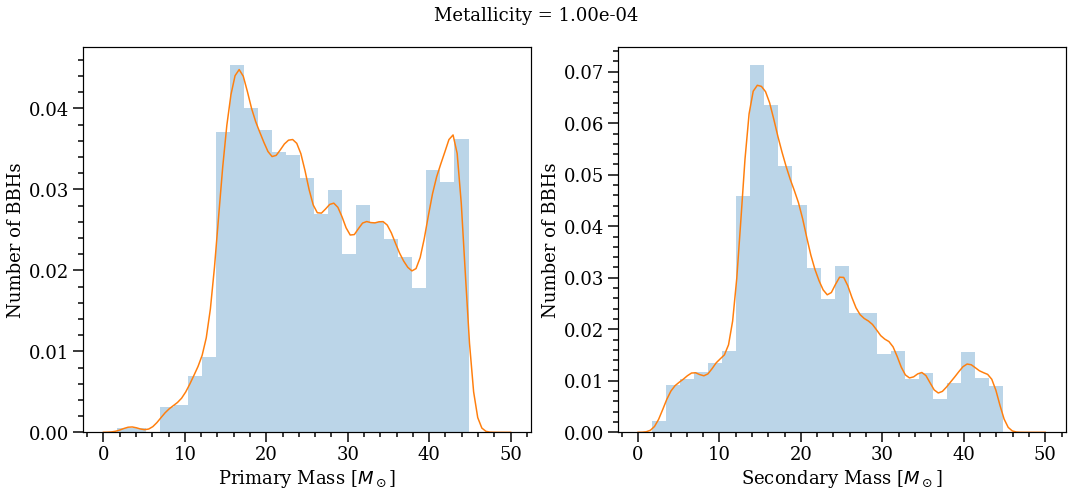

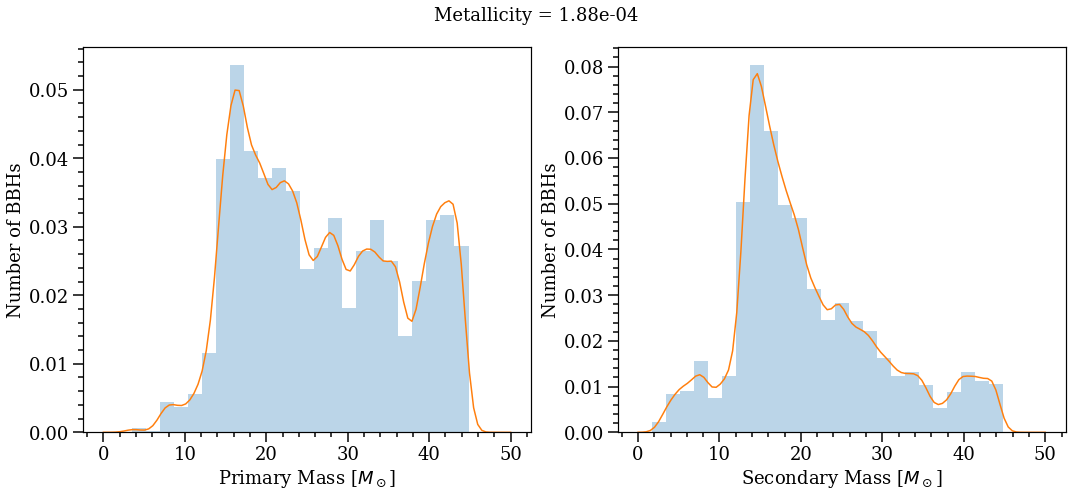

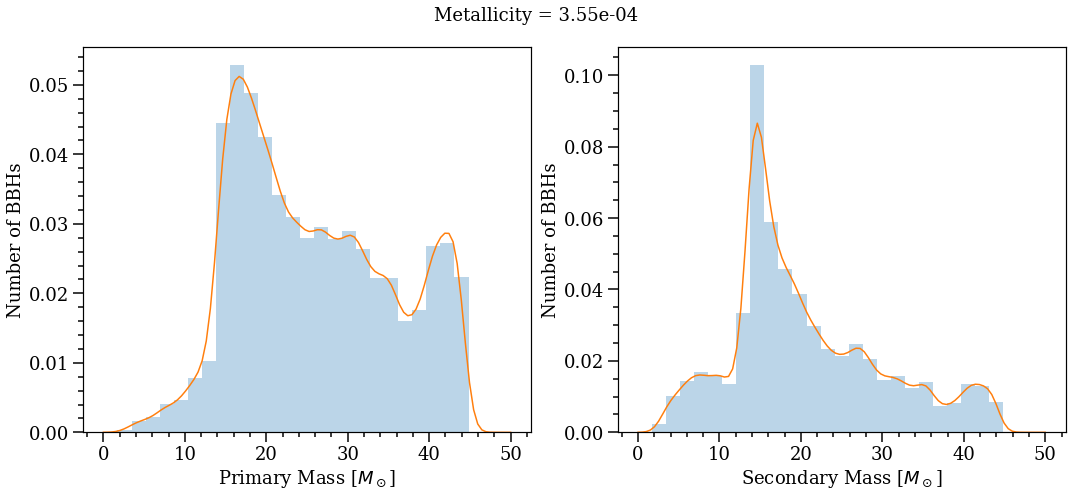

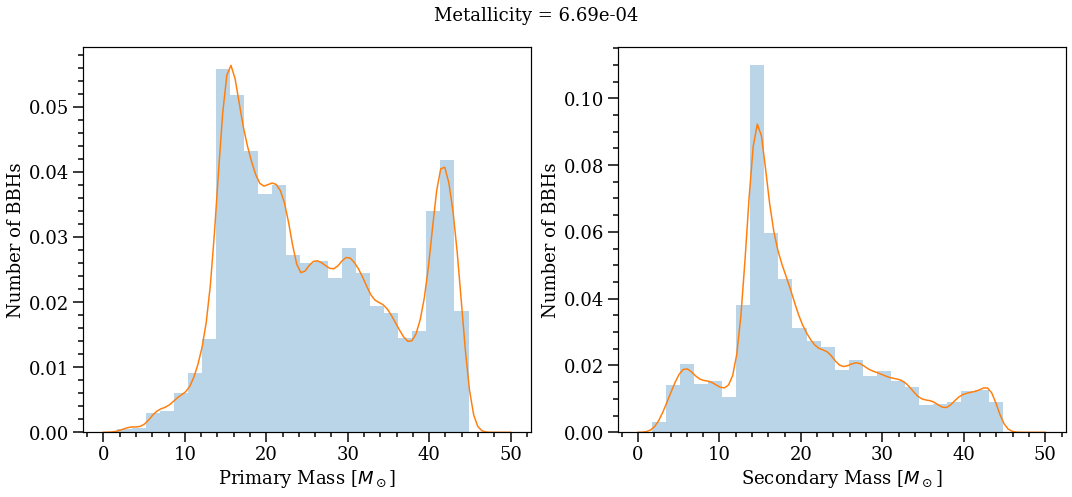

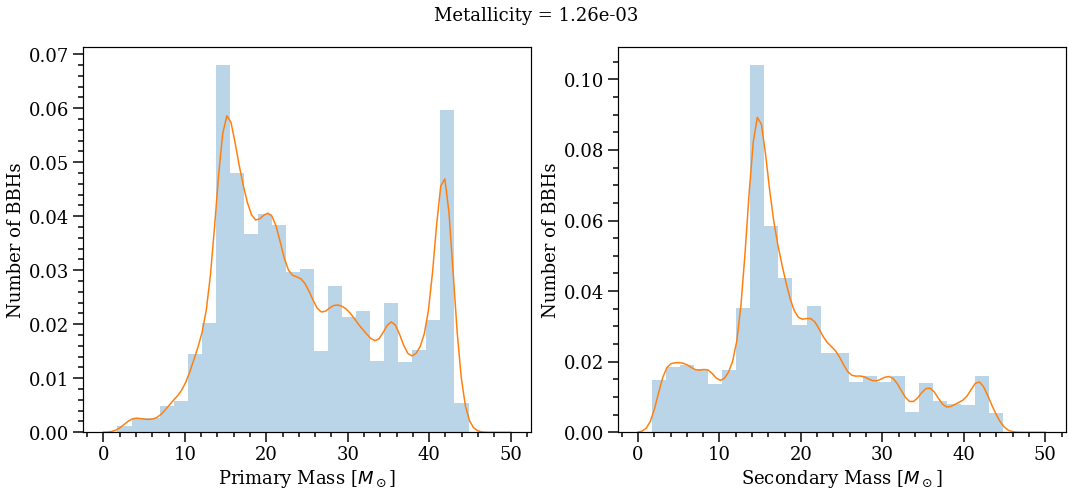

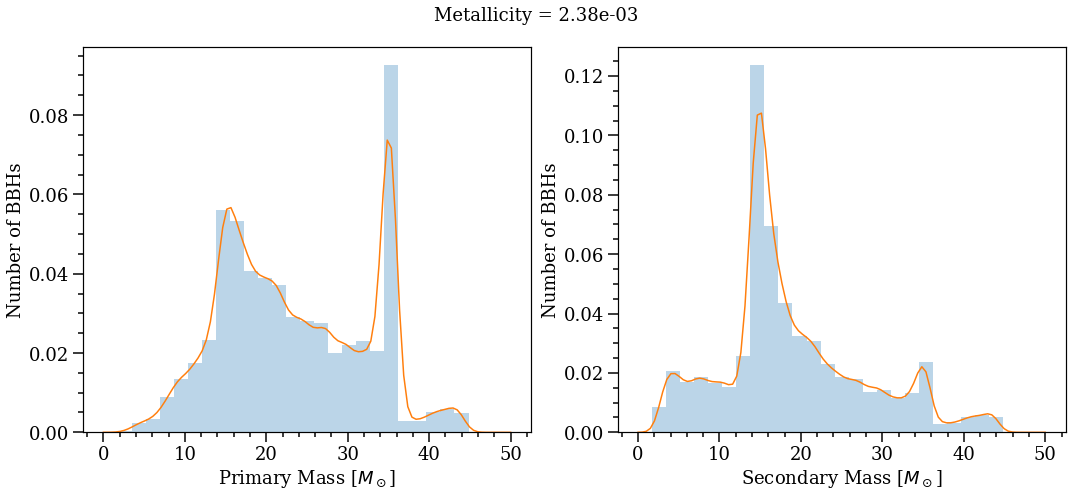

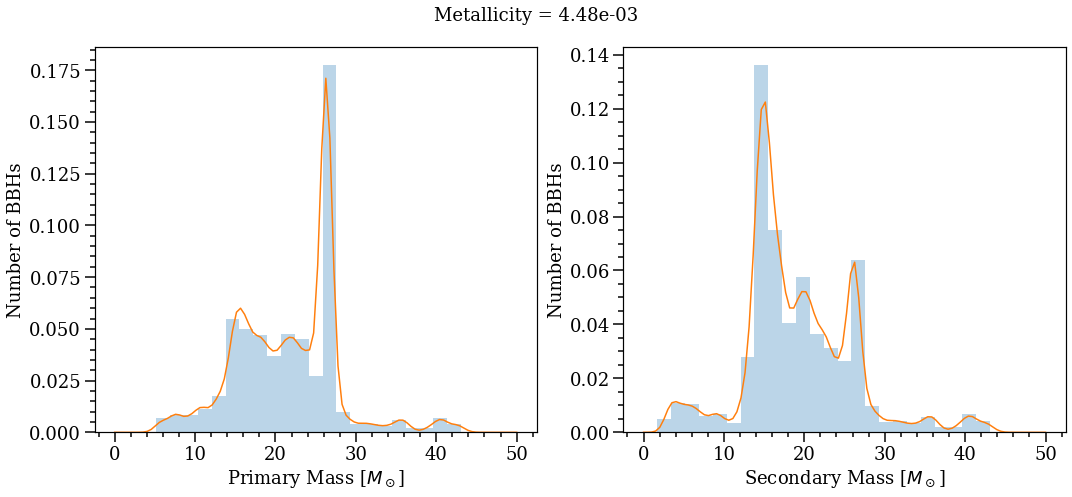

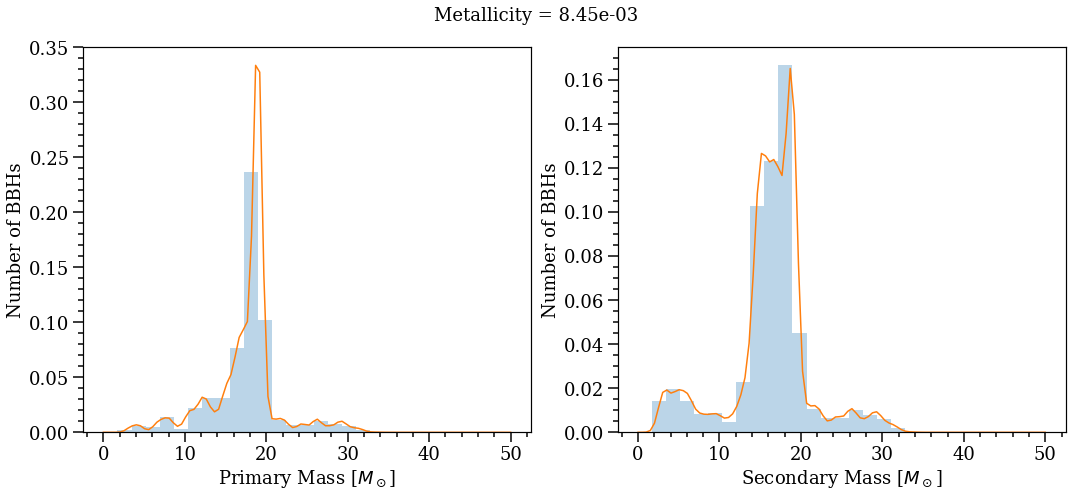

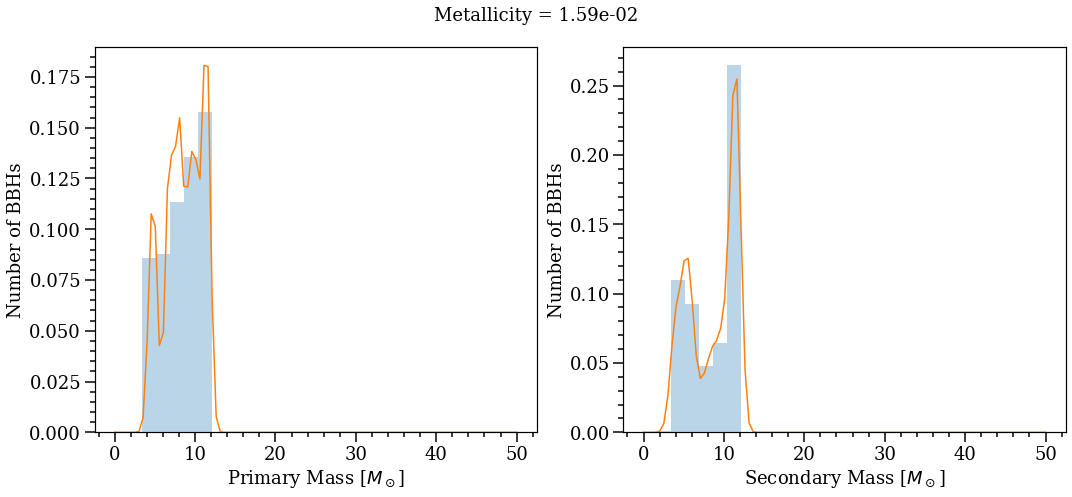

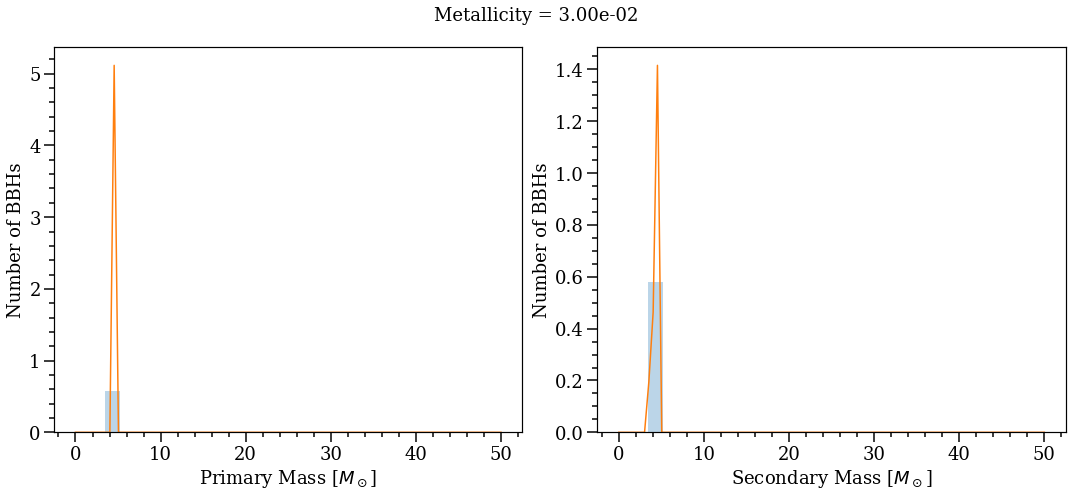

In [17]:
for m, metallicity in enumerate(metallicities[:]): 
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,7))
    fig.suptitle(f'Metallicity = {metallicity:.2e}', fontsize=18)
    bins = np.linspace(0, 50, 30)
            
    ax1.hist(M1_BBH_METS[m], bins=bins, density=True, alpha=0.3) 
    ax2.hist(M2_BBH_METS[m], bins=bins, density=True, alpha=0.3)
    
    kde_M1 = gaussian_kde( M1_BBH_METS[m] )
    kde_M1_dist_space = np.linspace( 0, 50, 100 )
    ax1.plot( kde_M1_dist_space, kde_M1(kde_M1_dist_space))
    
    kde_M2 = gaussian_kde( M2_BBH_METS[m] )
    kde_M2_dist_space = np.linspace( 0, 50, 100 )
    ax2.plot( kde_M2_dist_space, kde_M2(kde_M2_dist_space))
        

    layoutAxes(ax=ax1, nameX='Primary Mass [$M_\odot$]',\
           nameY='Number of BBHs')
    layoutAxes(ax=ax2, nameX='Secondary Mass [$M_\odot$]',\
           nameY='Number of BBHs')
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()

# Metallicity Log-Uniform Distribution peaks

In [6]:
fdata = h5.File(hobbs_pathData, 'r')

In [7]:
fdata['BSE_Double_Compact_Objects'].keys()

<KeysViewHDF5 ['Coalescence_Time', 'Eccentricity@DCO', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SEED', 'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time']>

In [8]:
M1_CO = fdata['BSE_Double_Compact_Objects']["Mass(1)"][()]
M2_CO = fdata['BSE_Double_Compact_Objects']["Mass(2)"][()]              

SMA_CO = fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]
ECC_CO = fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]

TYPE1_CO = fdata['BSE_Double_Compact_Objects']["Stellar_Type(1)"][()]
TYPE2_CO = fdata['BSE_Double_Compact_Objects']["Stellar_Type(2)"][()]

DELAY_TIMES = fdata['BSE_Double_Compact_Objects']["Coalescence_Time"][()]

SEED_CO = fdata['BSE_Double_Compact_Objects']["SEED"][()]

In [9]:
fdata['BSE_System_Parameters'].keys()

<KeysViewHDF5 ['CE_Alpha', 'CH_on_MS(1)', 'CH_on_MS(2)', 'Eccentricity@ZAMS', 'Equilibrated_At_Birth', 'Error', 'LBV_Factor', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'Merger', 'Merger_At_Birth', 'Metallicity@ZAMS(1)', 'Metallicity@ZAMS(2)', 'Omega@ZAMS(1)', 'Omega@ZAMS(2)', 'SEED', 'SN_Kick_Magnitude_Random_Number(1)', 'SN_Kick_Magnitude_Random_Number(2)', 'SemiMajorAxis@ZAMS', 'Sigma_Kick_CCSN_BH', 'Sigma_Kick_CCSN_NS', 'Sigma_Kick_ECSN', 'Sigma_Kick_USSN', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Stellar_Type@ZAMS(1)', 'Stellar_Type@ZAMS(2)', 'Unbound', 'WR_Factor']>

In [10]:
M1_ZAMS = fdata['BSE_System_Parameters']['Mass@ZAMS(1)'][()]
M2_ZAMS = fdata['BSE_System_Parameters']['Mass@ZAMS(2)'][()]

MET1_ZAMS = fdata['BSE_System_Parameters']['Metallicity@ZAMS(1)'][()]
MET2_ZAMS = fdata['BSE_System_Parameters']['Metallicity@ZAMS(2)'][()]

SEED_ZAMS = fdata['BSE_System_Parameters']['SEED'][()]

In [11]:
fdata.close()

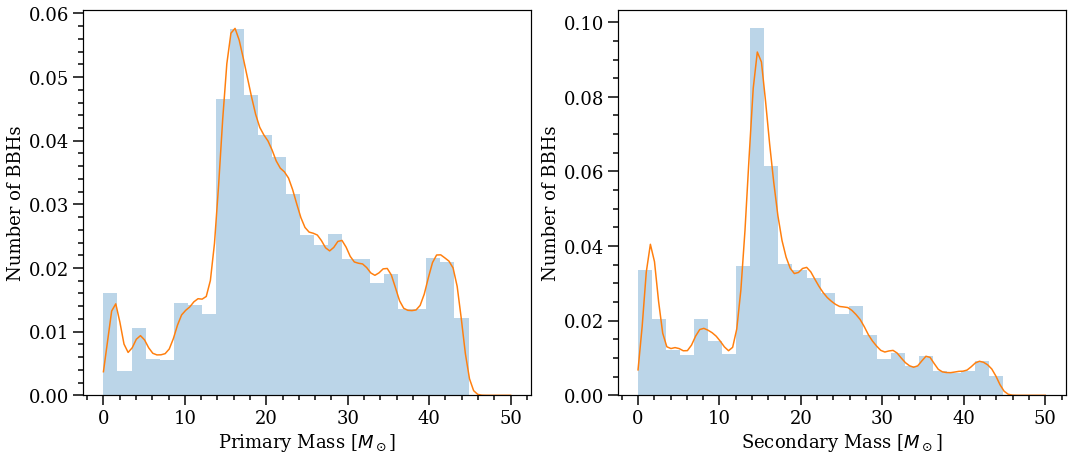

In [12]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,7))
bins = np.linspace(0, 50, 30)

ax1.hist(M1_CO, bins=bins, density=True, alpha=0.3) 
ax2.hist(M2_CO, bins=bins, density=True, alpha=0.3)

kde_M1 = gaussian_kde( M1_CO )
kde_M1_dist_space = np.linspace( 0, 50, 100 )
ax1.plot( kde_M1_dist_space, kde_M1(kde_M1_dist_space))

kde_M2 = gaussian_kde( M2_CO )
kde_M2_dist_space = np.linspace( 0, 50, 100 )
ax2.plot( kde_M2_dist_space, kde_M2(kde_M2_dist_space))


layoutAxes(ax=ax1, nameX='Primary Mass [$M_\odot$]',\
       nameY='Number of BBHs')
layoutAxes(ax=ax2, nameX='Secondary Mass [$M_\odot$]',\
       nameY='Number of BBHs')

fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

It looks like the artificial peaks issue will always happen if we simulate a single value of metallicity only. I think the correct solution would be to create a new grid, but in each metallicity bin I should simulate a log-normal metallicity dist around the required Z. 

Alternatively, I could just simulate a MASSIVE population using the LOGUNIFORM Metallicity dist in COMPAS if I could figure out a way to store the DCO metallicity as well.

# Try to match ZAMS with DCO to identify metallicity

In [122]:
data_co = {'M1_CO': M1_CO ,
           'M2_CO': M2_CO,
           'DELAY_TIMES': DELAY_TIMES,
           'TYPE1_CO': TYPE1_CO,
           'TYPE2_CO': TYPE2_CO}
 
# Creates pandas DataFrame.
df_co = pd.DataFrame(data_co, index=SEED_CO)

In [123]:
print(df_co.shape)
df_co.head()

(383264, 5)


,M1_CO,M2_CO,DELAY_TIMES,TYPE1_CO,TYPE2_CO
1654802618,28.157549,22.731678,2.644225e+19,14,14
1654802671,16.407829,14.353583,3.397824e+16,14,14
1654802696,35.709265,35.709265,1.534898e+02,14,14
1654802705,17.182051,20.852162,9.319286e+08,14,14
1654802713,17.851691,16.739270,1.211552e+16,14,14


In [124]:
data_zams = {'M1_ZAMS': M1_ZAMS ,
           'M2_ZAMS': M2_ZAMS,
           'MET1_ZAMS': MET1_ZAMS
          }
 
# Creates pandas DataFrame.
df_zams = pd.DataFrame(data_zams, index=SEED_ZAMS)

In [125]:
print(df_zams.shape)
df_zams.head()

(29107460, 3)


,M1_ZAMS,M2_ZAMS,MET1_ZAMS
1654802569,16.549691,13.634775,0.000438
1654802570,5.396256,3.445196,0.007859
1654802571,8.381638,0.813935,0.002880
1654802572,5.109324,3.235999,0.000635
1654802573,19.019741,11.553273,0.005109


In [17]:
# create a mask to select ZAMS that become DCOs
mask_ZAMS_to_CO = np.in1d(SEED_ZAMS, SEED_CO)
sum(mask_ZAMS_to_CO)

383264

In [126]:
# selected dataframe
df_zams_co = df_zams.loc[mask_ZAMS_to_CO]
print(df_zams_co.shape)
df_zams_co.head()

(383264, 3)


,M1_ZAMS,M2_ZAMS,MET1_ZAMS
1654802618,68.296587,56.471188,0.000298
1654802671,43.763578,35.337091,0.000561
1654802696,39.800804,39.800804,0.000661
1654802705,46.892779,32.652745,0.000167
1654802713,70.706505,65.907013,0.006115


In [127]:
print(df_zams_co.shape)

(383264, 3)


In [128]:
# combined dataframe with DCOs and ZAMS info
df_merged = pd.concat([df_co, df_zams_co], axis=1)

In [129]:
# select bbhs
df_bbh = df_merged[df_merged['TYPE1_CO'] + df_merged['TYPE2_CO'] == 28]

In [130]:
df_bbh

,M1_CO,M2_CO,DELAY_TIMES,TYPE1_CO,TYPE2_CO,M1_ZAMS,M2_ZAMS,MET1_ZAMS
1654802618,28.157549,22.731678,2.644225e+19,14,14,68.296587,56.471188,0.000298
1654802671,16.407829,14.353583,3.397824e+16,14,14,43.763578,35.337091,0.000561
1654802696,35.709265,35.709265,1.534898e+02,14,14,39.800804,39.800804,0.000661
1654802705,17.182051,20.852162,9.319286e+08,14,14,46.892779,32.652745,0.000167
1654802713,17.851691,16.739270,1.211552e+16,14,14,70.706505,65.907013,0.006115
1654802740,16.170930,14.575423,9.515051e+19,14,14,41.537609,35.773010,0.000263
1654802812,22.071850,19.578187,3.668720e+18,14,14,53.797786,48.401335,0.000127
1654802989,17.945494,20.882720,1.678972e+09,14,14,48.140782,34.070552,0.000115
1654803008,11.551990,17.843559,1.176027e+03,14,14,38.533081,26.370344,0.000203
1654803068,15.276597,9.630374,4.735846e+04,14,14,44.088124,34.845225,0.001462


# Sample BBHs using Metallicity value

## Bin dataframe by metallicity

In [131]:
N_bins = 100
met_bin_edges = np.logspace(np.log10(min(MET1_ZAMS)), np.log10(max(MET1_ZAMS)), N_bins + 1)
met_bin_edges

array([0.0001    , 0.00010587, 0.00011208, 0.00011866, 0.00012563,
       0.000133  , 0.00014081, 0.00014907, 0.00015782, 0.00016709,
       0.00017689, 0.00018728, 0.00019827, 0.00020991, 0.00022223,
       0.00023527, 0.00024908, 0.0002637 , 0.00027918, 0.00029556,
       0.00031291, 0.00033128, 0.00035072, 0.00037131, 0.0003931 ,
       0.00041618, 0.0004406 , 0.00046647, 0.00049385, 0.00052283,
       0.00055352, 0.00058601, 0.0006204 , 0.00065682, 0.00069537,
       0.00073619, 0.0007794 , 0.00082515, 0.00087358, 0.00092485,
       0.00097914, 0.00103661, 0.00109745, 0.00116187, 0.00123006,
       0.00130226, 0.0013787 , 0.00145962, 0.0015453 , 0.001636  ,
       0.00173203, 0.00183369, 0.00194132, 0.00205526, 0.0021759 ,
       0.00230361, 0.00243883, 0.00258197, 0.00273352, 0.00289397,
       0.00306383, 0.00324366, 0.00343405, 0.00363562, 0.00384901,
       0.00407493, 0.00431411, 0.00456733, 0.00483541, 0.00511923,
       0.0054197 , 0.00573782, 0.0060746 , 0.00643115, 0.00680

In [132]:
met_bin_centers = np.mean(np.vstack([met_bin_edges[0:-1],met_bin_edges[1:]]), axis=0)
len(met_bin_centers)

100

In [133]:
met_bin_centers

array([0.00010294, 0.00010898, 0.00011537, 0.00012215, 0.00012931,
       0.0001369 , 0.00014494, 0.00015345, 0.00016245, 0.00017199,
       0.00018208, 0.00019277, 0.00020409, 0.00021607, 0.00022875,
       0.00024218, 0.00025639, 0.00027144, 0.00028737, 0.00030424,
       0.0003221 , 0.000341  , 0.00036102, 0.00038221, 0.00040464,
       0.00042839, 0.00045354, 0.00048016, 0.00050834, 0.00053818,
       0.00056976, 0.00060321, 0.00063861, 0.0006761 , 0.00071578,
       0.00075779, 0.00080227, 0.00084936, 0.00089922, 0.000952  ,
       0.00100787, 0.00106703, 0.00112966, 0.00119597, 0.00126616,
       0.00134048, 0.00141916, 0.00150246, 0.00159065, 0.00168401,
       0.00178286, 0.0018875 , 0.00199829, 0.00211558, 0.00223976,
       0.00237122, 0.0025104 , 0.00265775, 0.00281375, 0.0029789 ,
       0.00315375, 0.00333886, 0.00353483, 0.00374231, 0.00396197,
       0.00419452, 0.00444072, 0.00470137, 0.00497732, 0.00526947,
       0.00557876, 0.00590621, 0.00625287, 0.00661989, 0.00700

need to simulate more bbhs for Z = 0.008 and above

In [134]:
# number of BBHs in each bin
N_BBHS_MET = np.zeros(len(met_bin_centers))
for i in range(len(met_bin_centers)):
    df_sample = df_bbh[(df_bbh['MET1_ZAMS'] >= met_bin_edges[i]) & (df_bbh['MET1_ZAMS'] <= met_bin_edges[i+1])]
    N_BBHS_MET[i] = len(df_sample)
N_BBHS_MET

array([7162., 5430., 4788., 4534., 5644., 5798., 7370., 7142., 6112.,
       4574., 5898., 4146., 5664., 6500., 6152., 6306., 7182., 4982.,
       5410., 5684., 5644., 3444., 7610., 6236., 5410., 4126., 4146.,
       6306., 3912., 3872., 5858., 5276., 3270., 7182., 3484., 6948.,
       8232., 2822., 5002., 4360., 5002., 4554., 4106., 2608., 1732.,
       1966., 6052., 4400., 4320., 5584., 3434., 2862., 3718., 3698.,
       3718., 3210., 3698., 3036., 4166., 2588., 1538., 3698., 4808.,
       2414., 3210., 1712., 3270., 3464., 3464., 3270., 3464., 1712.,
       3056., 1946., 1966., 1090.,  214., 1946.,  876., 2140., 1752.,
        428.,  642.,  662.,  642.,  428.,    0.,    0.,  214.,    0.,
          0.,  214.,  448.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.])

In [135]:
# UNTIL I SIMULATE MORE BBHS, limit the metallicity range to something usable
met_bin_centers = met_bin_centers[:80]

## get number of BBHs to sample for each bin

In [136]:
from scipy import stats

def met_to_met_weights(met, metallicities):
    SIGMA_Z = 0.39
    log_metallicities = np.log10(metallicities)
    log_met = np.log10(met)
    weights = np.zeros(len(log_metallicities))

    for i in range(len(log_metallicities)):
        mu = log_metallicities[i]
        weights[i] = stats.norm.pdf(log_met, mu, SIGMA_Z)
    weights = weights/np.sum(weights)
    return weights 

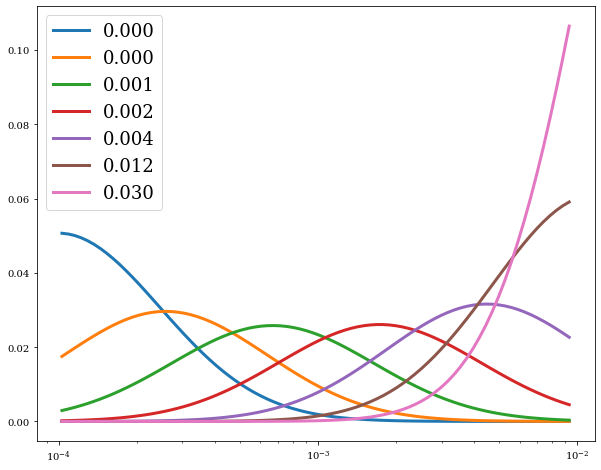

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))

for met in np.logspace(np.log10(min(MET1_ZAMS)), np.log10(max(MET1_ZAMS)), 7): 
    weights_test = met_to_met_weights(met, met_bin_centers)
    plt.plot(met_bin_centers, weights_test, lw=3, label=f'{met:.3f}')

plt.legend(fontsize=fm)
plt.semilogx()
plt.show()

## sample these bbhs

In [102]:
met = 0.00214
n_bbh = 90578
weights = met_to_met_weights(met, met_bin_centers)
n_met_samples = (weights*n_bbh).astype(int)
n_met_samples

array([   7,    9,   12,   14,   18,   22,   26,   32,   39,   46,   55,
         66,   78,   92,  108,  126,  147,  171,  197,  227,  260,  297,
        338,  382,  431,  484,  541,  603,  669,  739,  813,  891,  973,
       1058, 1145, 1235, 1326, 1419, 1512, 1604, 1695, 1784, 1871, 1953,
       2031, 2104, 2170, 2230, 2282, 2325, 2360, 2386, 2403, 2409, 2407,
       2394, 2372, 2341, 2300, 2252, 2195, 2131, 2061, 1985, 1904, 1820,
       1731, 1641, 1549, 1456, 1364, 1272, 1181, 1093, 1007,  924,  844,
        768,  697,  629])

In [104]:
i = 70

print(f"To sample: {n_met_samples[i]} BBHs")

df_sample = df_bbh[(df_bbh['MET1_ZAMS'] >= met_bin_edges[i]) & (df_bbh['MET1_ZAMS'] <= met_bin_edges[i+1])]
print(f"BBHs available to sample: {len(df_sample)}")

df_sampled_bbhs = df_sample.sample(n_met_samples[i], replace=True)
print(f"Actually sampled (with replacement): {len(df_sampled_bbhs)}")
df_sampled_bbhs

To sample: 1364 BBHs
BBHs available to sample: 3464
Actually sampled (with replacement): 1364


,M1_CO,M2_CO,TYPE1_CO,TYPE2_CO,M1_ZAMS,M2_ZAMS,MET1_ZAMS
1656452807,17.540963,15.722415,14,14,66.508643,54.010487,0.005528
1654822983,23.842333,23.815121,14,14,130.015787,115.907247,0.005500
1656461688,23.124301,17.299986,14,14,91.471822,65.549865,0.005517
1656493810,20.744109,20.744109,14,14,31.975153,31.975153,0.005493
1656476658,23.932894,23.968836,14,14,139.288207,127.297017,0.005422
1654819336,12.753510,15.605061,14,14,50.937555,50.816093,0.005638
1656493810,20.744109,20.744109,14,14,31.975153,31.975153,0.005493
1654822983,23.842333,23.815121,14,14,130.015787,115.907247,0.005500
1654822983,23.842333,23.815121,14,14,130.015787,115.907247,0.005500
1656518627,23.900979,23.766469,14,14,139.516655,110.406695,0.005484


## Create combined Numpy arrays for M1, M2, Metallicity

In [138]:
# import the local tools to sample BBH population
from cosmo_bbh_tools import cosmo_bbh_tools as cbt
from scipy import interpolate
import json

In [139]:
n_systems_all = [5e1, 5e2, 5e3, 5e4, 5e5, 5e6]
n_systems = n_systems_all[:]
print(n_systems)

zminn = 0.000100 # COMPAS MIN
zmaxx = 0.030000 # COMPAS MAX
Z_MIN_LOG = np.log10(zminn)
Z_MAX_LOG = np.log10(zmaxx)

metallicities = np.logspace(Z_MIN_LOG, Z_MAX_LOG, 10)
print(metallicities)

output_dir = "raw_data"
fname = f"sfm"
with open(f"{output_dir}/{fname}",'r') as infile:
    sfm = json.load(infile)
    
fname = f"M1_BBH_ALL"
with open(f"{output_dir}/{fname}",'r') as infile:
    M1_BBH_ALL = json.load(infile) 

# if all else fails, use a precomputed list of SFMs
# sfm = [2973.8073414654723, 31923.208597062316, 359218.0101252408, 3755139.5369435307, 37528597.22264311, 375972740.71117413]

print(sfm)

[50.0, 500.0, 5000.0, 50000.0, 500000.0, 5000000.0]
[0.0001     0.00018847 0.0003552  0.00066943 0.00126166 0.00237782
 0.0044814  0.00844598 0.01591789 0.03      ]
[2973.8073414654723, 31923.208597062316, 359218.0101252408, 3755139.5369435307, 37528597.22264311, 375972740.71117413]


In [166]:
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
H0 = cosmo.H(0)
t0 = 1.0/H0
t0_Myr = t0.decompose().to(u.Myr)
T_HUBBLE_MYR = t0_Myr.value
print(T_HUBBLE_MYR)

14105.485021361645


In [157]:
# set some arbitrary values of sfm, Z
SFM = 3.7e6
MET = 0.000359

In [158]:
# Create an interpolator to calculate the number of BBH binaries at each SFM, Metallicity value pair
met_sfm_to_n_bbh = cbt.interpolate_n_bbh(sfm, metallicities, M1_BBH_ALL)
n_bbh = met_sfm_to_n_bbh(MET, SFM)
print(n_bbh)

[970.58910778]


In [198]:
weights = cbt.met_to_met_weights(MET, met_bin_centers)
n_met_samples = [round(num) for num in (weights*n_bbh)]
print(n_met_samples)
np.sum(n_met_samples)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 24, 25, 25, 26, 26, 26, 27, 27, 27, 26, 26, 26, 25, 25, 24, 23, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 7, 6, 5, 5, 4, 4, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


971

In [199]:
import itertools
start = time.time()

M1_SAMPLED = []
M2_SAMPLED = []
DELAY_TIME_SAMPLED = []

for i in range(len(met_bin_centers)):
    df_sample = df_bbh[(df_bbh['MET1_ZAMS'] >= met_bin_edges[i]) & (df_bbh['MET1_ZAMS'] <= met_bin_edges[i+1])]
    df_sampled_bbhs = df_sample.sample(n_met_samples[i], replace=True)
    M1_SAMPLED.append(df_sampled_bbhs['M1_CO'].tolist())
    M2_SAMPLED.append(df_sampled_bbhs['M2_CO'])
    DELAY_TIME_SAMPLED.append(df_sampled_bbhs['DELAY_TIMES'])

M1_SAMPLED = list(itertools.chain(*M1_SAMPLED))
M2_SAMPLED = list(itertools.chain(*M2_SAMPLED))
DELAY_TIME_SAMPLED = list(itertools.chain(*DELAY_TIME_SAMPLED))

end = time.time()
print(f"Sampling completed in {end-start:.2f} s")    

Sampling completed in 0.34 s


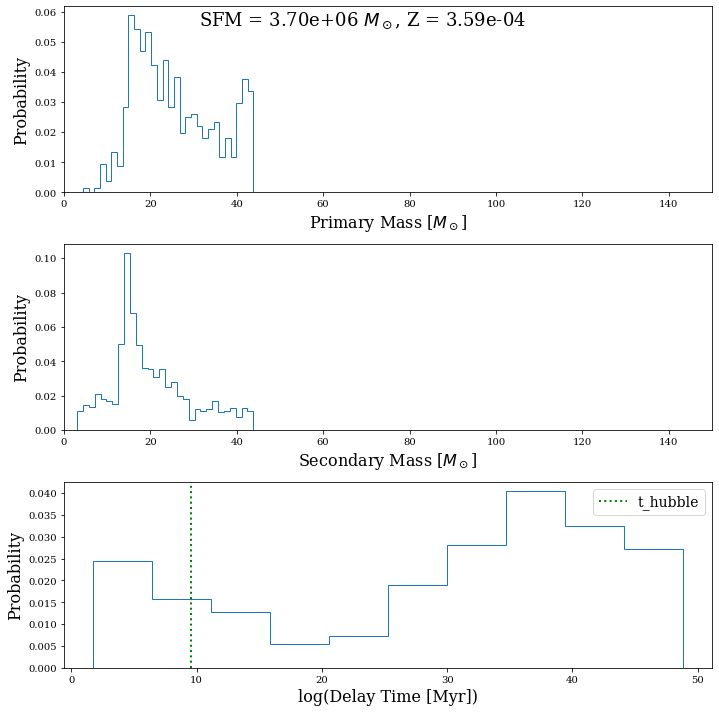

In [201]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

fig.suptitle(f"SFM = {SFM:.2e} $M_\odot$, Z = {MET:.2e}", fontsize=18)

bins = 30

ax1.hist(M1_SAMPLED, bins=bins, histtype='step', density=True)
ax1.set_xlabel("Primary Mass [$M_\odot$]", fontsize=16)
ax1.set_ylabel("Probability", fontsize=16)
ax1.set_xlim(0,150)

ax2.hist(M2_SAMPLED, bins=bins, histtype='step', density=True)
ax2.set_xlabel("Secondary Mass [$M_\odot$]", fontsize=16)
ax2.set_ylabel("Probability", fontsize=16)
ax2.set_xlim(0,150)


ax3.axvline(x=np.log(T_HUBBLE_MYR), color='green', ls=':', lw=2, label='t_hubble')
ax3.hist(np.log(DELAY_TIME_SAMPLED), histtype='step', density=True)
ax3.set_xlabel("log(Delay Time [Myr])", fontsize=16)
ax3.set_ylabel("Probability", fontsize=16)
ax3.legend(fontsize=14)

plt.tight_layout()
plt.show()

# Bin by metallicity

In [213]:
start = time.time()

M1_BBH_METS_LOGUNIFORM = []
M2_BBH_METS_LOGUNIFORM = []
DELAY_TIME_BBH_METS_LOGUNIFORM = []

for i in range(len(met_bin_centers)):
    df_sample = df_bbh[(df_bbh['MET1_ZAMS'] >= met_bin_edges[i]) & (df_bbh['MET1_ZAMS'] <= met_bin_edges[i+1])]
    
    M1_BBH_METS_LOGUNIFORM.append(df_sample['M1_CO'].tolist())
    M2_BBH_METS_LOGUNIFORM.append(df_sample['M2_CO'].tolist())
    DELAY_TIME_BBH_METS_LOGUNIFORM.append(df_sample['DELAY_TIMES'].tolist())



end = time.time()
print(f"Binning completed in {end-start:.2f} s")  

Binning completed in 0.17 s


In [212]:
M1_BBH_METS_LOGUNIFORM

[[43.58393432900555,
  17.74566942178187,
  38.8792839007613,
  18.429660111377448,
  43.420225897713344,
  43.58393432900555,
  17.74566942178187,
  38.8792839007613,
  18.429660111377448,
  43.420225897713344,
  43.58393432900555,
  17.74566942178187,
  38.8792839007613,
  18.429660111377448,
  43.420225897713344,
  43.58393432900555,
  17.74566942178187,
  38.8792839007613,
  18.429660111377448,
  43.420225897713344,
  43.58393432900555,
  17.74566942178187,
  38.8792839007613,
  18.429660111377448,
  43.420225897713344,
  43.58393432900555,
  17.74566942178187,
  38.8792839007613,
  18.429660111377448,
  43.420225897713344,
  43.58393432900555,
  17.74566942178187,
  38.8792839007613,
  18.429660111377448,
  43.420225897713344,
  43.58393432900555,
  17.74566942178187,
  38.8792839007613,
  18.429660111377448,
  43.420225897713344,
  43.58393432900555,
  17.74566942178187,
  38.8792839007613,
  18.429660111377448,
  43.420225897713344,
  43.58393432900555,
  17.74566942178187,
  38